
## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	2 pt: implement basic regression and classification tasks
*	2 pt: explore advanced optimizers and regularization methods (both tasks)
*	1 pt: optimize hyperparameters using grid/random search and cross-validation (both tasks)
*	2 pt: implement CNN for classification task
*	1 pt: visualize weight histograms, activation profiles and receptive fields


In [1]:
!pip install skorch==0.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1.Regression task

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn. preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from sklearn.model_selection import cross_val_score
from skorch import NeuralNetRegressor
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping
from numpy import mean
from numpy import std
import os

torch.manual_seed(2041389)

output_folders = {
    "GENERATED_IMAGES_LOSS": f'./generated_images/loss'
}

for key, value in output_folders.items():
    if (not os.path.exists(value)):
        os.makedirs(value)

def convert_to_pytorch_tensor(numpy_array):
    numpy_array = np.expand_dims(numpy_array, axis = 1)
    numpy_array = torch.from_numpy(numpy_array).float()
    print(numpy_array.size(), min(numpy_array), max(numpy_array))
    return numpy_array

def extract_data(dataset):
    x = convert_to_pytorch_tensor(dataset[:, 0])
    y = convert_to_pytorch_tensor(dataset[:, 1])
    return x, y

def load_data():
    train_df = pd.read_csv('regression_dataset/train_data.csv')
    test_df = pd.read_csv('regression_dataset/test_data.csv')
    
    print('Extracting train data:')
    x_train, y_train = extract_data(train_df.values)
    print('Extracting test data:')
    x_test, y_test = extract_data(test_df.values)

    data = {
        "train_df": train_df,
        "test_df": test_df,
        "x_train": x_train,
        "y_train": y_train,
        "x_test": x_test,
        "y_test": y_test
    }
    return data

def plot(df, plot_label, title=None):
    plt.figure(figsize=(12,8))
    plt.scatter(df.input, df.label, label=plot_label)
    plt.xlabel('input')
    plt.ylabel('label')
    if (title is not None):
        plt.title(title)
    plt.legend()
    plt.show()

def plot_loss(train_loss, valid_loss, title=None):
    plt.figure(figsize=(12,8))
    plt.plot(train_loss, color = 'blue')
    #min_train_loss = min(train_loss)
    #x = train_loss.index(min_train_loss)
    #plt.annotate(round(min_train_loss, 2), xy = (x, min_train_loss), xytext = (x, min_train_loss), color = 'blue')
    plt.plot(valid_loss, color = 'orange')
    validation_loss = valid_loss[-1]
    x = valid_loss.index(validation_loss)
    plt.annotate(round(validation_loss, 2), xy = (x, validation_loss), xytext = (x+0.75, validation_loss+0.25), color = 'orange')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Train loss', 'Validation loss'])
    if (title is not None):
        plt.title(title)
        plt.savefig(f'{output_folders["GENERATED_IMAGES_LOSS"]}/{title}', dpi=300)
    plt.show()

!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv 

--2022-07-08 15:51:41--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3.7K) [text/plain]
Saving to: ‘regression_dataset/train_data.csv.1’

train_data.csv.1    100%[===================>]   3.69K  --.-KB/s    in 0s      

2022-07-08 15:51:42 (63.4 MB/s) - ‘regression_dataset/train_data.csv.1’ saved [3776/3776]

--2022-07-08 15:51:42--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3.7K) [text/plain]
Saving to: ‘regression_dataset/test_data.csv.1’

test_dat

##### Loading Data
data is a dict with the keys below. The train and test data are tensor objects.
- `train_df`
- `test_df`
- `x_train`
- `y_train`
- `x_test`
- `y_test`

Extracting train data:
torch.Size([100, 1]) tensor([-4.9159]) tensor([4.9775])
torch.Size([100, 1]) tensor([-3.7430]) tensor([7.1993])
Extracting test data:
torch.Size([100, 1]) tensor([-4.9999]) tensor([4.8949])
torch.Size([100, 1]) tensor([-2.9999]) tensor([6.3360])


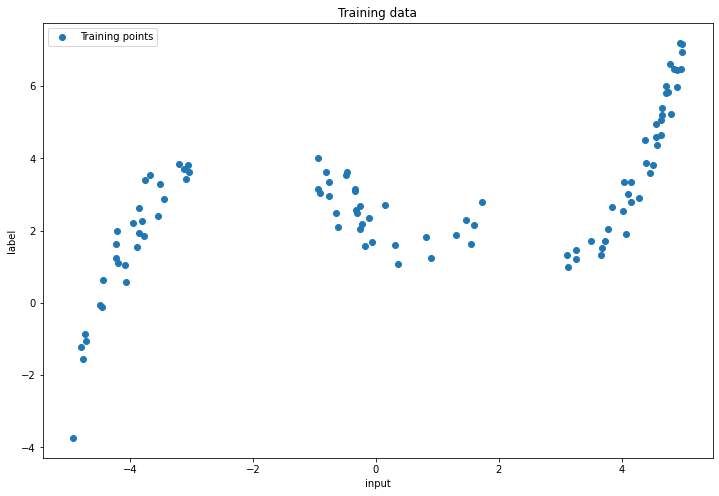

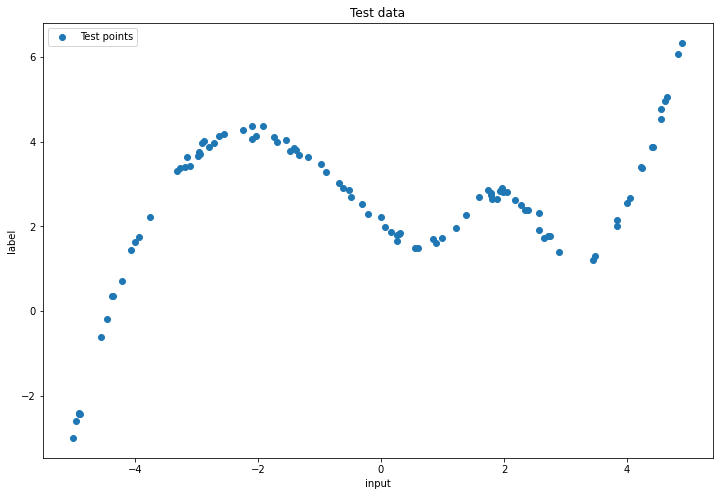

In [3]:
data = load_data()

plot(data["train_df"], 'Training points', 'Training data')
plot(data["test_df"], 'Test points', 'Test data')

##### Define Network and hyperparameters

In [4]:
# Define a fully connected feed-forward network with 3 hidden layers.
class Net(nn.Module):
    run_id = 0
    def __init__(self, Ni, Nh1, Nh2, Nh3, No, dropout1, dropout2, dropout3):
        super().__init__()
        print(f'({Net.run_id}) Network initialized')
        Net.run_id += 1
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.fc3 = nn.Linear(in_features=Nh2, out_features=Nh3)
        self.out = nn.Linear(in_features=Nh3, out_features=No)

        #self.dropout1 = nn.Dropout(dropout1)
        #self.dropout2 = nn.Dropout(dropout2)
        #self.dropout3 = nn.Dropout(dropout3)

        self.softplus = nn.Softplus()
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

        
        
    def forward(self, x, additional_out=False):
        x = self.tanh(self.fc1(x))
        #x = self.dropout1(x)

        x = self.softplus(self.fc2(x))
        #x = self.dropout2(x)

        x = self.relu(self.fc3(x))
        #x = self.dropout3(x)

        x = self.out(x)
        return x

def get_neural_net_regressor_instance():
    return NeuralNetRegressor(
        module = Net,
        module__Ni = 1,
        module__dropout1 = 0.1,
        module__Nh1 = 256,
        module__dropout2 = 0.1,
        module__Nh2 = 512,
        module__dropout3 = 0.1,
        module__Nh3 = 768,
        module__No = 1,
        
        # L2 regularization
        optimizer = optim.Adam,
        optimizer__lr = 0.001,
        optimizer__weight_decay = 1e-7,
        
        max_epochs = 500,
        batch_size = 16,
        criterion = nn.MSELoss,
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        callbacks = [
            EarlyStopping(
                monitor = 'valid_loss',
                patience = 400,
                threshold = 0.0001,
                threshold_mode = 'rel',
                lower_is_better = True
            )
        ],
        verbose = 0
    )

net_reg = get_neural_net_regressor_instance()

##### Training

In [5]:
net_reg.fit(data['x_train'], data['y_train'])

(0) Network initialized


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Net(
    (fc1): Linear(in_features=1, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=768, bias=True)
    (out): Linear(in_features=768, out_features=1, bias=True)
    (softplus): Softplus(beta=1, threshold=20)
    (relu): ReLU()
    (tanh): Tanh()
  ),
)

##### Plot loss

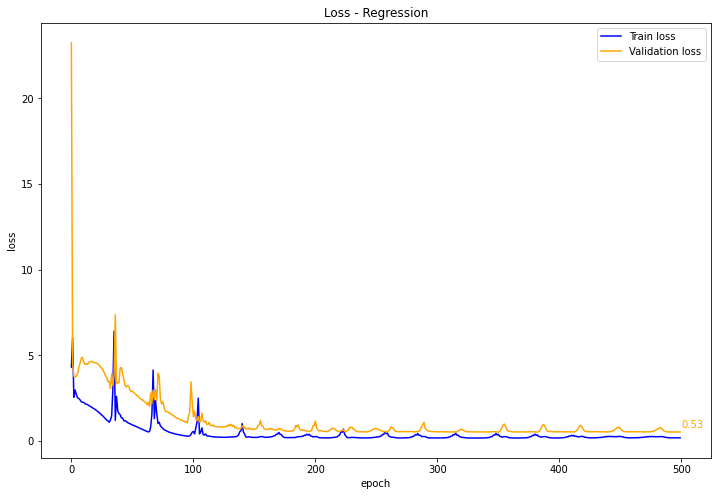

Train loss: 0.1943925440311432
Validation loss: 0.5318272829055786


In [6]:
history = net_reg.history
train_loss_history = history[:, 'train_loss']
validation_loss_history = history[:, 'valid_loss']
plot_loss(train_loss_history, validation_loss_history, 'Loss - Regression')
print(f'Train loss: {train_loss_history[-1]}')
print(f'Validation loss: {validation_loss_history[-1]}')

##### Testing the model - Predict using test dataset

Train Loss:	 0.194
Valid. Loss:	 0.532
Test Loss:	 0.135


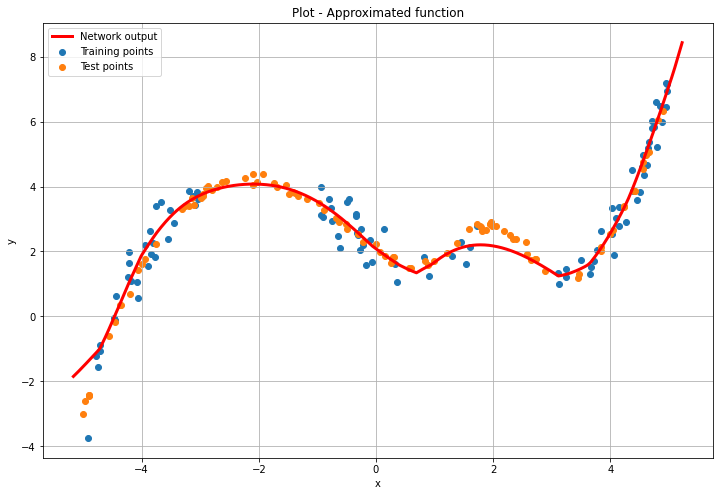

In [7]:
def predict_model(model, loss_function, device, history):
    y_pred = model.predict(data['x_test'])
    y_pred = torch.from_numpy(y_pred).float()
    
    test_loss = loss_function(y_pred, data['y_test'])
    train_loss_history = history[:, 'train_loss']
    validation_loss_history = history[:, 'valid_loss']
    print("Train Loss:\t", round(train_loss_history[-1], 3))
    print("Valid. Loss:\t", round(validation_loss_history[-1], 3))
    print("Test Loss:\t", round(test_loss.item(), 3))

    x_vec = torch.linspace(data['train_df'].input.min() - 0.25, data['train_df'].input.max() + 0.25, 1000)
    x_vec = x_vec.to(device)
    x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector

    y_vec = model.predict(x_vec)
    y_vec = torch.from_numpy(y_vec).float()

    plt.figure(figsize=(12,8))
    plt.scatter(data['train_df'].input, data['train_df'].label, label='Training points')
    plt.scatter(data['test_df'].input, data['test_df'].label, label='Test points')
    #pairs = sorted(zip(data['x_test'], y_pred))
    #x, y = [ list(tuple) for tuple in zip(*pairs) ]

    plt.plot(x_vec.squeeze(), y_vec.squeeze(), label='Network output', color='red', linewidth=3)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Plot - Approximated function')
    plt.grid()
    plt.legend()
    plt.show()

predict_model(net_reg, net_reg.criterion(), net_reg.device, net_reg.history)

##### GridSearch

In [8]:
params = {
    'optimizer__lr': [0.001, 0.0013, 0.0015],
    'optimizer__weight_decay':[1e-5, 1e-7],
    'batch_size': [16, 32, 64]
}

# doc: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# cv = None --> "None, to use the default 5-fold cross validation"
gs = GridSearchCV(net_reg, params, refit=True, scoring='r2', verbose=1, cv=3, error_score="raise")
gs.fit(data['x_train'], data['y_train'])
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
(1) Network initialized
(2) Network initialized
(3) Network initialized
(4) Network initialized
(5) Network initialized
(6) Network initialized
(7) Network initialized
(8) Network initialized
(9) Network initialized
(10) Network initialized
(11) Network initialized
(12) Network initialized
(13) Network initialized
(14) Network initialized
(15) Network initialized
(16) Network initialized
(17) Network initialized
(18) Network initialized
(19) Network initialized
(20) Network initialized
(21) Network initialized
(22) Network initialized
(23) Network initialized
(24) Network initialized
(25) Network initialized
(26) Network initialized
(27) Network initialized
(28) Network initialized
(29) Network initialized
(30) Network initialized
(31) Network initialized
(32) Network initialized
(33) Network initialized
(34) Network initialized
(35) Network initialized
(36) Network initialized
(37) Network initialized
(38) Network initialize

## Network output (using GridSearch)

Train Loss:	 0.209
Valid. Loss:	 0.592
Test Loss:	 0.122


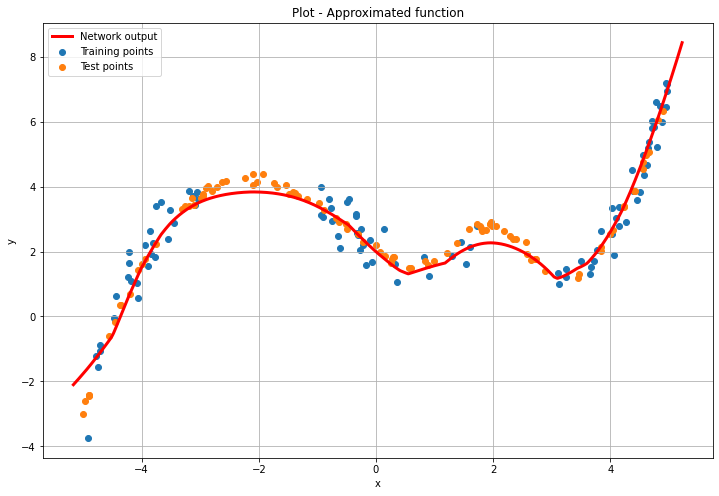

In [9]:
predict_model(gs, net_reg.criterion(), net_reg.device, gs.best_estimator_.history)

### Access network parameters

In [10]:
# First hidden layer
h1_w = net_reg.module_.fc1.weight.data.cpu().numpy()
h1_b = net_reg.module_.fc1.bias.data.cpu().numpy()

# Second hidden layer
h2_w = net_reg.module_.fc2.weight.data.cpu().numpy()
h2_b = net_reg.module_.fc2.bias.data.cpu().numpy()

# Third hidden layer
h3_w = net_reg.module_.fc3.weight.data.cpu().numpy()
h3_b = net_reg.module_.fc3.bias.data.cpu().numpy()

# Output layer
out_w = net_reg.module_.out.weight.data.cpu().numpy()
out_b = net_reg.module_.out.bias.data.cpu().numpy()

#### Weights histogram

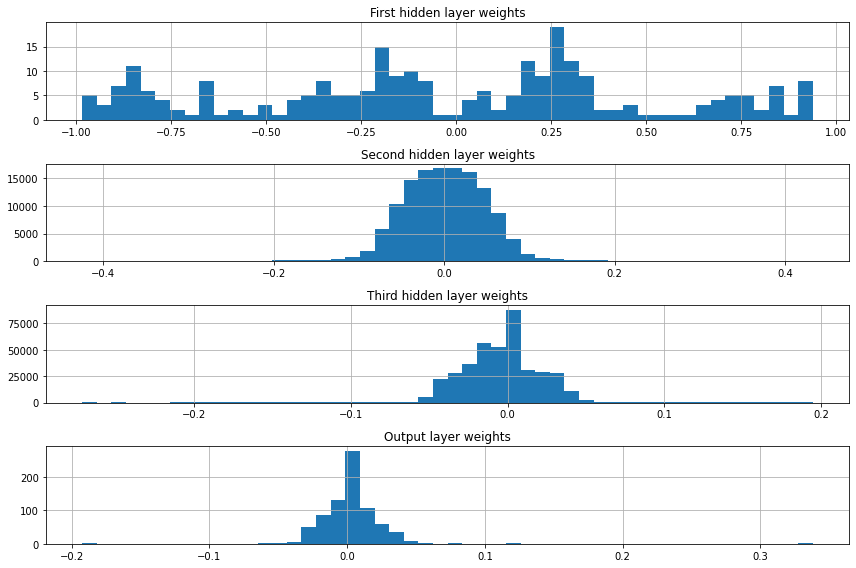

In [11]:
# Weights histogram
fig, axs = plt.subplots(4, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(h3_w.flatten(), 50)
axs[2].set_title('Third hidden layer weights')
axs[3].hist(out_w.flatten(), 50)
axs[3].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

#### Save network parameters

In [12]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_state_dict = net_reg.module_.state_dict()
print(net_state_dict.keys())
# Save the state dict to a file
torch.save(net_state_dict, 'net_parameters.torch')

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'out.weight', 'out.bias'])


#### Save optimizer state

In [13]:
### Save the optimizer state
torch.save(net_reg.optimizer_.state_dict(), 'optimizer_state.torch')

### Reload the optimizer state
optimizer = optim.Adam(net_reg.module_.parameters(), lr=0.001)
opt_state_dict = torch.load('optimizer_state.torch')
optimizer.load_state_dict(opt_state_dict)

#### Load network

In [14]:
### Reload the network state
# First initialize the network (if not already done)
# IMPORTANT: you need to know the model definition!!
net = Net(net_reg.module__Ni, net_reg.module__Nh1, net_reg.module__Nh2, net_reg.module__Nh3, net_reg.module__No, net_reg.module__dropout1, net_reg.module__dropout2, net_reg.module__dropout3)
# Load the state dict previously saved
net_state_dict = torch.load('net_parameters.torch')
# Update the network parameters
net.load_state_dict(state_dict=net_state_dict)

(56) Network initialized


<All keys matched successfully>

#### Analyze activations

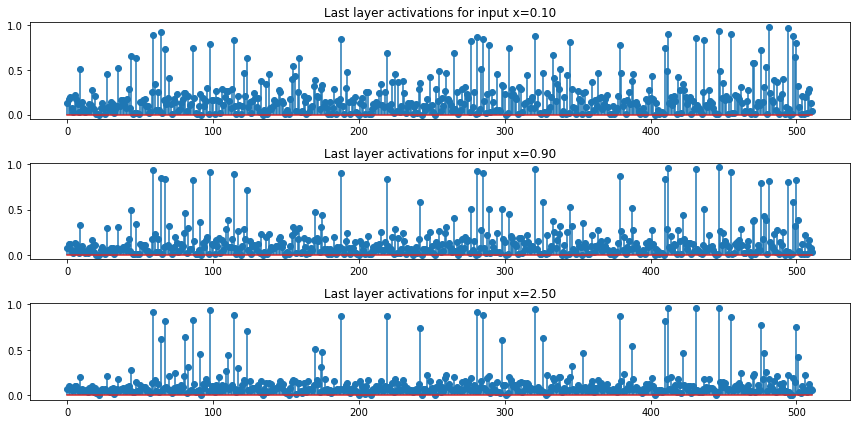

In [15]:
# First naive way: simply change the network definition to return an additional output

# More advanced strategy: using hooks

def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)

### Register hook  
hook_handle = net.fc2.register_forward_hook(get_activation)
device = net_reg.device
### Analyze activations
net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor([0.1]).float().to(device)
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor([0.9]).float().to(device)
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor([2.5]).float().to(device)
    y3 = net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.show()

# Classification task

## Guidelines

* The goal is to train a neural network that maps an input image (from fashionMNIST) to one of ten classes (multi-class classification problem with mutually exclusive classes).
* Define a proper loss (e.g. [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))
* Also here, consider to create a validation set from you training data, or use a k-fold cross-validation strategy.
* Pay attention to the shape, data type and output values range. If needed, modify them accordingly to your implementation (read carefully the documentation of the layers that you use, e.g. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)).
* Explore different optimizers, acivation functions, network architectures. Analyze the effect of different regularization methods, such as dropout layers, random transformations (image rotation, scaling, add noise...) or L2 regularization (weight decay).

## Dataset

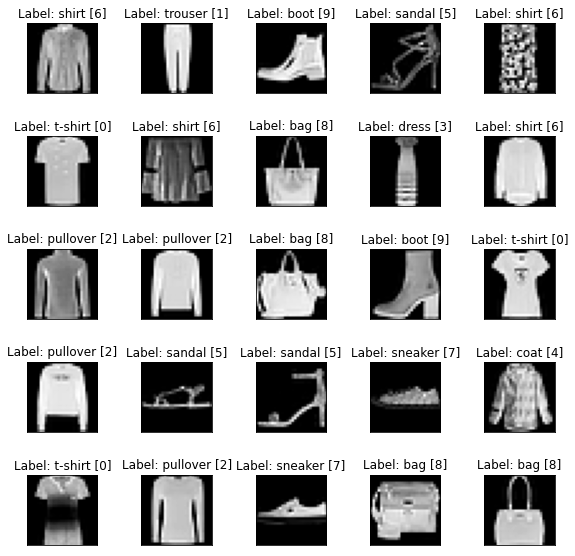

In [16]:
import torch
from pathlib import Path
import pandas as pd
import numpy as np
import random
import torchvision
import matplotlib.pyplot as plt
import torchvision.datasets as dsts
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
import itertools

import torch.optim as optim
import torch.nn.functional as F
import torch.nn as NN
import torch.nn as nn
torch.__version__

torch.manual_seed(0)

output_folders = {
    "GENERATED_IMAGES_LOSS": f'./generated_images/loss'
}

class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.transform = transform
        self.data = []


def load_classification_data(plot_samples = True):
    train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
    test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)

    #train_dataset.transform = transforms.Compose([transforms.ToTensor(),])
    #test_dataset.transform = transforms.Compose([transforms.ToTensor(),])
    
    #load the data to use them
    #train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = len(train_dataset), shuffle = True)
    #test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = len(test_dataset), shuffle = True) 

    

    #train_size = int(0.75 * len(train_dataset))
    #validation_size = len(train_dataset) - train_size
    #train_set, validation_set = torch.utils.data.random_split(train_dataset, [train_size, validation_size])

    classification_data = {
        "train_dataset": train_dataset,
        "test_dataset": test_dataset
    }

    if (plot_samples):
        ### Plot some sample
        label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
                    'sneaker','bag','boot']
        fig, axs = plt.subplots(5, 5, figsize=(8,8))
        for ax in axs.flatten():
            # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
            img, label = random.choice(train_dataset)
            ax.imshow(np.array(img), cmap='gist_gray')
            ax.set_title(f'Label: {label_names[label]} [{label}]')
            ax.set_xticks([])
            ax.set_yticks([])
        plt.tight_layout()

    return classification_data

def plot_classification_loss(train_loss, valid_loss, title=None):
    plt.figure(figsize=(12,8))
    plt.plot(train_loss, color = 'blue')
    #min_train_loss = min(train_loss)
    #x = train_loss.index(min_train_loss)
    #plt.annotate(round(min_train_loss, 2), xy = (x, min_train_loss), xytext = (x, min_train_loss), color = 'blue')
    plt.plot(valid_loss, color = 'orange')
    validation_loss = valid_loss[-1]
    x = valid_loss.index(validation_loss)
    plt.annotate(round(validation_loss, 2), xy = (x, validation_loss), xytext = (x, validation_loss), color = 'orange')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Train loss', 'Validation loss'])
    if (title is not None):
        plt.title(title)
        plt.savefig(f'{output_folders["GENERATED_IMAGES_LOSS"]}/{title}', dpi=300)
    plt.show()

classification_data = load_classification_data()

In [17]:
classification_data['train_dataset'].transform = transforms.Compose([transforms.ToTensor(),])
classification_data['test_dataset'].transform = transforms.Compose([transforms.ToTensor(),])
train_loader = torch.utils.data.DataLoader(dataset = classification_data['train_dataset'], batch_size = len(classification_data['train_dataset']), shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = classification_data['test_dataset'], batch_size = len(classification_data['test_dataset']), shuffle = True)
x_train, y_train = next(iter(train_loader))
x_test, y_test = next(iter(test_loader))

classification_data['x_train'] = x_train
classification_data['y_train'] = y_train
classification_data['x_test'] = x_test
classification_data['y_test'] = y_test

In [18]:
img, label = random.choice(classification_data['train_dataset'])
img.size()

torch.Size([1, 28, 28])

#### Implement classification task using neural networks
##### Define network model

In [19]:
class NetCNN(nn.Module):
    run_id = 0
    def __init__(self, conv1, conv2, conv_dropout, dropout1, Nh1, Nh2, No):
        super().__init__()
        print(f'({NetCNN.run_id}) Network initialized')
        NetCNN.run_id += 1
        self.conv1 = nn.Conv2d(1, conv1, kernel_size = 3)
        self.conv2 = nn.Conv2d(conv1, conv2, kernel_size = 3)

        Ni = conv2*5*5
        print(Ni)
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)

        self.dropout1 = nn.Dropout(dropout1)
        self.conv_dropout = nn.Dropout2d(conv_dropout)

        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.batchnorm1 = nn.BatchNorm2d(num_features = conv1)
        self.batchnorm2 = nn.BatchNorm2d(num_features = conv2)

        self.maxpool1 = nn.MaxPool2d((2, 2))
        self.maxpool2 = nn.MaxPool2d((2, 2), stride = (2, 2))
        
    def forward(self, x, additional_out=False):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.batchnorm1(x)
        x = self.maxpool1(x)
        #x = self.dropout1(x)
        x = self.conv_dropout(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.batchnorm2(x)
        x = self.maxpool2(x)
        x = self.conv_dropout(x)
        
        # flatten over channel, height and width = 64 * 5 * 5
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        #x = torch.flatten(x)
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.dropout1(x)
        x = self.relu(x)
        x = self.out(x)
        x = self.softmax(x)
        return x

def get_cnn_instance():
    return NeuralNetClassifier(
        #  conv1, conv2, conv_dropout, dropout, Nh1, No
        module = NetCNN,
        module__Nh1 = 128,
        module__Nh2 = 256,
        module__No = 10,
        module__conv1 = 32,
        module__conv2 = 48,
        module__conv_dropout = 0.2,
        module__dropout1 = 0.2,
        
        # L2 regularization
        optimizer = optim.Adam,
        optimizer__lr = 0.0001,
        optimizer__weight_decay = 1e-7,
        
        max_epochs = 15,
        batch_size = 32,
        criterion = nn.CrossEntropyLoss, # for classification we use CrossEntropyLoss
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        callbacks = [
            EarlyStopping(
                monitor = 'valid_loss',
                patience = 500,
                threshold = 0.0001,
                threshold_mode = 'rel',
                lower_is_better = True
            )
        ],
        verbose = 0
    )

net_cnn = get_cnn_instance()

##### Training

In [20]:
net_cnn.fit(classification_data['x_train'], classification_data['y_train'])

(0) Network initialized
1200


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=NetCNN(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
    (fc1): Linear(in_features=1200, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=256, bias=True)
    (out): Linear(in_features=256, out_features=10, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (conv_dropout): Dropout2d(p=0.2, inplace=False)
    (softmax): Softmax(dim=1)
    (relu): ReLU()
    (tanh): Tanh()
    (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchnorm2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  ),
)

##### Plot train and validation losses

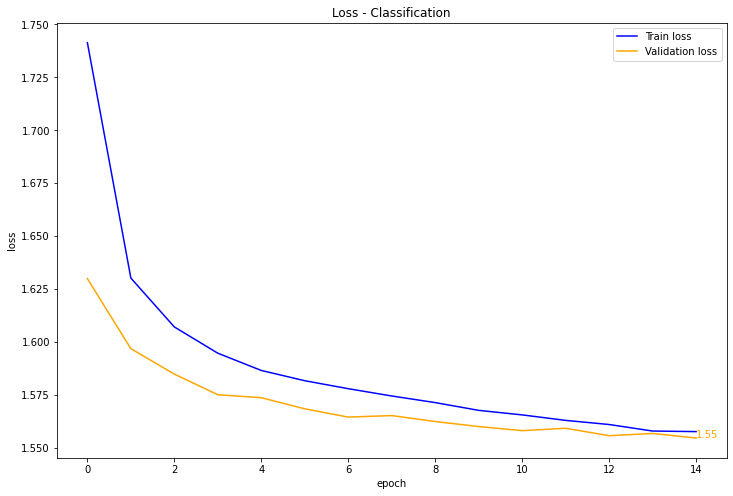

Train loss: 1.557593032280604
Validation loss: 1.5545532251993814


In [21]:
history = net_cnn.history
train_loss_history = history[:, 'train_loss']
validation_loss_history = history[:, 'valid_loss']
plot_classification_loss(train_loss_history, validation_loss_history, 'Loss - Classification')
print(f'Train loss: {train_loss_history[-1]}')
print(f'Validation loss: {validation_loss_history[-1]}')

##### Testing the model - Predict using test dataset and Confusion Matrix

Train Loss:	 1.558
Val Acc:	 0.906
Test Acc:	 0.898
Precision:	 0.898
Recall:		 0.898
F1:		 0.898


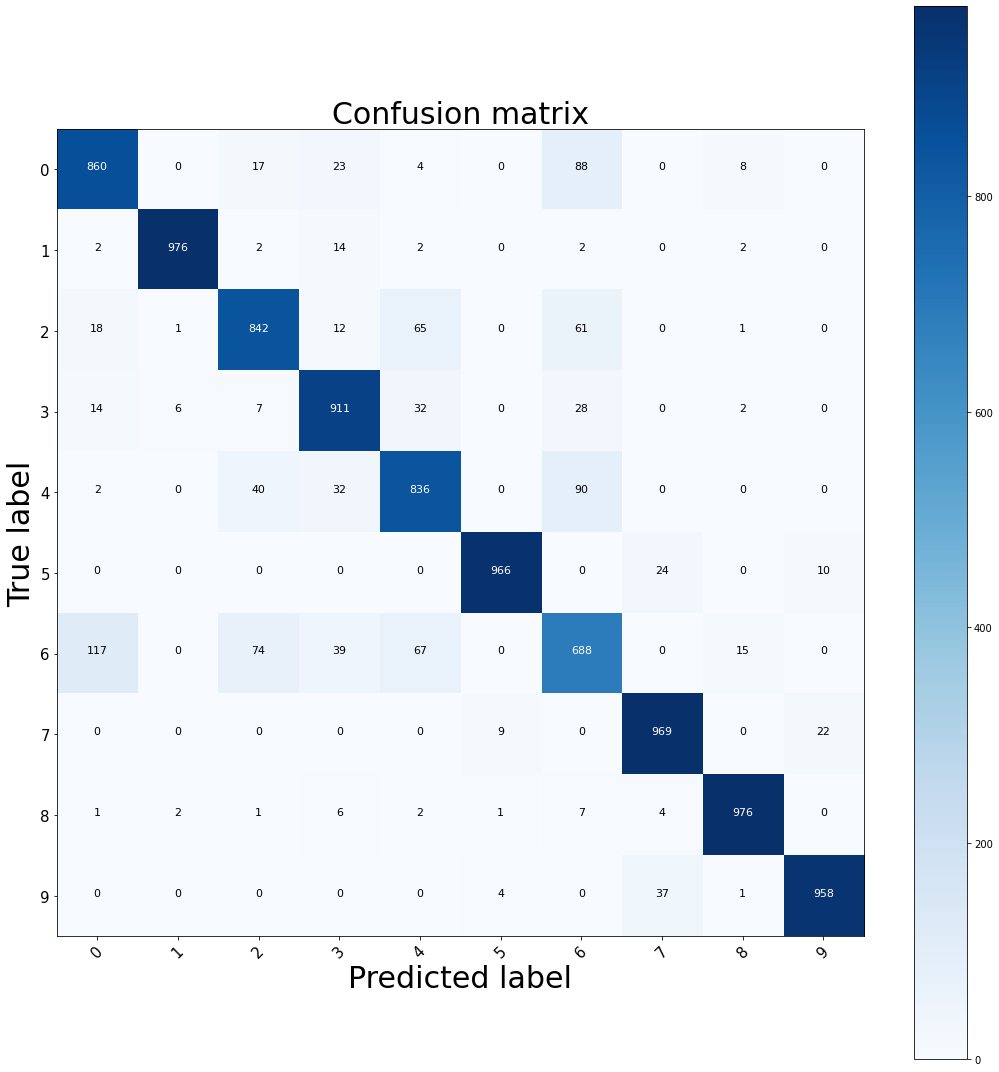

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
						  save_path='models/'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), size=11,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)
    plt.savefig(save_path+"_picConfMatrix.png", dpi=400)
    plt.tight_layout()

y_pred = net_cnn.predict(classification_data['x_test'])
y_pred = torch.from_numpy(y_pred)
    
test_acc = accuracy_score(classification_data['y_test'], y_pred)

#Accuracy
val_acc=history[:, 'valid_acc'][-1]
val_loss=history[:, 'valid_loss'][-1]
train_loss=history[:, 'train_loss'][-1]

print("Train Loss:\t",round(train_loss,3))
print("Val Acc:\t",round(val_acc,3))
print("Test Acc:\t",round(float(test_acc),3))

# Precision and Recall(sensitivity/true positive rate)
from sklearn.metrics import precision_score, recall_score
prec=precision_score(y_test, y_pred,average='micro')
rec=recall_score(y_test, y_pred,average='micro')

#F1 - high if both recall and precision are high.
from sklearn.metrics import f1_score
f1=f1_score(y_test, y_pred,average='micro')

print("Precision:\t",round(prec,3))
print("Recall:\t\t",round(rec,3))
print("F1:\t\t",round(f1,3))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
categories=[0,1,2,3,4,5,6,7,8,9]
plot_confusion_matrix(cm,categories, normalize=False,save_path=f'{output_folders["GENERATED_IMAGES_LOSS"]}/confusion_matrix')

#### Grid search 

In [23]:

params = {
    #'module__conv1':[32,64],
    #'module__conv2':[48,64],
   # 'optimizer__lr': [0.001, 0.0001],
   # 'optimizer__weight_decay':[1e-5, 1e-7],
    'batch_size': [32, 64]
}

gs = GridSearchCV(net_cnn, params, refit=True, scoring='r2', verbose=1, cv=3, error_score="raise")
gs.fit(classification_data['x_train'], classification_data['y_train'])
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))


Fitting 3 folds for each of 2 candidates, totalling 6 fits
(1) Network initialized
1200
(2) Network initialized
1200
(3) Network initialized
1200
(4) Network initialized
1200
(5) Network initialized
1200
(6) Network initialized
1200
(7) Network initialized
1200
best score: 0.827, best params: {'batch_size': 32}


##### Training again

In [25]:
#predict_model(gs, net_cnn.criterion(), net_cnn.device, gs.best_estimator_.history)

In [26]:
## plot train loss and validation loss using new parameters
'''

history = gs.best_estimator_.history
train_loss_history = history[:, 'train_loss']
validation_loss_history = history[:, 'valid_loss']
plot_classification_loss(train_loss_history, validation_loss_history, 'Loss - Classification (GridSearch)')
print(f'Train loss: {train_loss_history[-1]}')
print(f'Validation loss: {validation_loss_history[-1]}')'''

"\n\nhistory = gs.best_estimator_.history\ntrain_loss_history = history[:, 'train_loss']\nvalidation_loss_history = history[:, 'valid_loss']\nplot_classification_loss(train_loss_history, validation_loss_history, 'Loss - Classification (GridSearch)')\nprint(f'Train loss: {train_loss_history[-1]}')\nprint(f'Validation loss: {validation_loss_history[-1]}')"

In [27]:
# Changing the net_cnn to the best fitted model
#net_cnn = gs.best_estimator_

In [28]:
## plot train loss and validation loss using new parameters
'''
history = net_cnn.history
train_loss_history = history[:, 'train_loss']
validation_loss_history = history[:, 'valid_loss']
plot_classification_loss(train_loss_history, validation_loss_history, 'Loss - Classification')
print(f'Train loss: {train_loss_history[-1]}')
print(f'Validation loss: {validation_loss_history[-1]}')
'''

"\nhistory = net_cnn.history\ntrain_loss_history = history[:, 'train_loss']\nvalidation_loss_history = history[:, 'valid_loss']\nplot_classification_loss(train_loss_history, validation_loss_history, 'Loss - Classification')\nprint(f'Train loss: {train_loss_history[-1]}')\nprint(f'Validation loss: {validation_loss_history[-1]}')\n"

##### Weights histogram

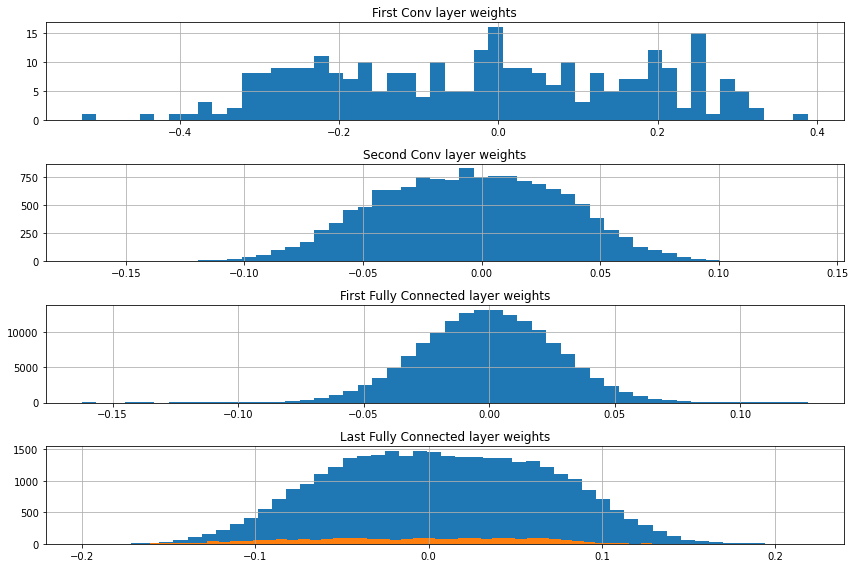

In [29]:
#Access network parameters
net = net_cnn.module_

c1_w = net.conv1.weight.data.cpu().numpy()
c2_w = net.conv2.weight.data.cpu().numpy()
h1_w = net.fc1.weight.data.cpu().numpy()
h2_w = net.fc2.weight.data.cpu().numpy()
out_w = net.out.weight.data.cpu().numpy()

# Weights histogram
fig, axs = plt.subplots(4, 1, figsize=(12,8))
axs[0].hist(c1_w.flatten(), 50)
axs[0].set_title('First Conv layer weights')
axs[1].hist(c2_w.flatten(), 50)
axs[1].set_title('Second Conv layer weights')
axs[2].hist(h1_w.flatten(), 50)
axs[2].set_title('First Fully Connected layer weights')
axs[3].hist(h2_w.flatten(), 50)
axs[3].set_title('Second Fully Connected layer weights')
axs[3].hist(out_w.flatten(), 50)
axs[3].set_title('Last Fully Connected layer weights')

[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

##### Analyze activations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


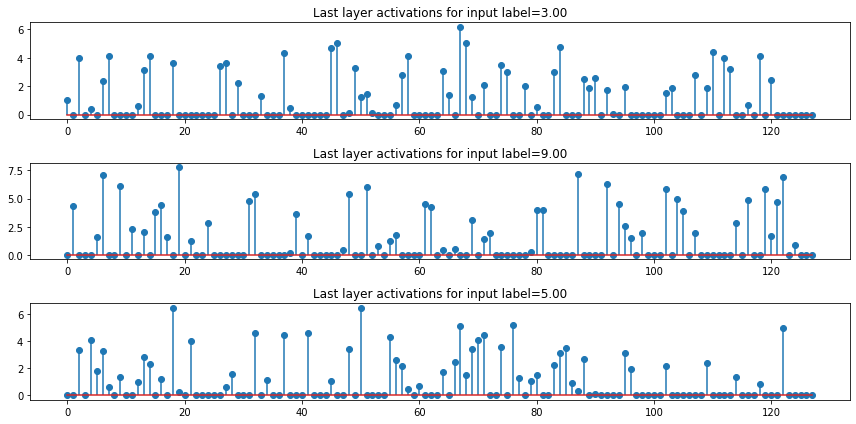

In [30]:
def get_activation(layer, input, output):
    global activation
    #activation = torch.softmax(output)
    activation = torch.relu(output)

device = net_cnn.device

### Register hook
net = net_cnn.module_
hook_handle = net.fc1.register_forward_hook(get_activation)


### Analyze activations
net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor(classification_data['x_train'][0]).unsqueeze(0).to(device)
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor(classification_data['x_train'][1]).unsqueeze(0).to(device)
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor(classification_data['x_train'][2]).unsqueeze(0).to(device)
    y3 = net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy()[0], use_line_collection=True)
axs[0].set_title('Last layer activations for input label=%.2f' % y_train[0])
axs[1].stem(z2.cpu().numpy()[0], use_line_collection=True)
axs[1].set_title('Last layer activations for input label=%.2f' % y_train[1])
axs[2].stem(z3.cpu().numpy()[0], use_line_collection=True)
axs[2].set_title('Last layer activations for input label=%.2f' % y_train[2])
plt.tight_layout()
plt.show()

## Receptive fields

(1200,)
(1200,)
(1200,)
(1200,)
(1200,)


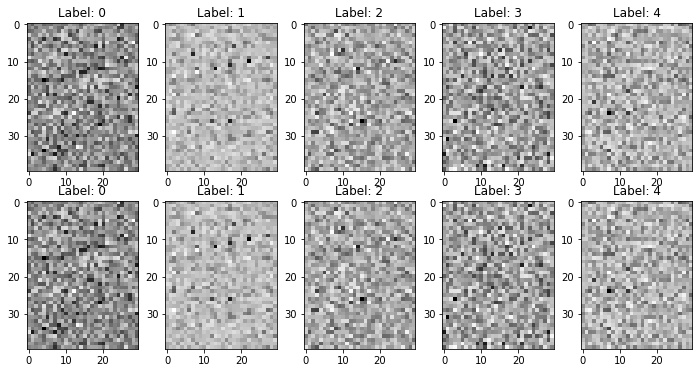

In [31]:
#Receptive fields of the last layer
fig, axs = plt.subplots(2, 5, figsize=(12,6))
for ii in range(5):
    vis3 = np.matmul(out_w[ii], np.matmul(h2_w,h1_w))
    print(vis3.shape)
    v = vis3.reshape(40,30)
    axs[0][ii].imshow(v, cmap='Greys')
    axs[0][ii].set_title("Label: "+str(ii))
    axs[1][ii].imshow(v, cmap='Greys')
    axs[1][ii].set_title("Label: "+str(ii))
    
plt.show()

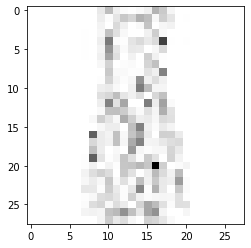

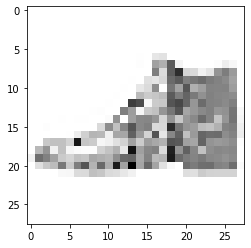

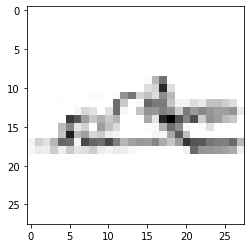

In [32]:
def visualize_receptive_field(image):
    input = torch.ones_like(image, requires_grad=True)
    out = net(input)
    sig = nn.Sigmoid()
    
    prediction = torch.argmax(sig(net(image)), dim=1) #prediction of the true image
    #print(sig(out))

    grad = torch.zeros_like(out, requires_grad=True)
    with torch.no_grad():
        grad[0][prediction] = 1
    #print(grad)

    out.backward(gradient=grad)
    gradient_of_input = input.grad[0, 0].data.cpu().numpy()
    gradient_of_input = gradient_of_input / np.amax(gradient_of_input)

    def normalize(activations):
        # transform activations so that all the values be in range [0, 1]
        activations = activations - np.min(activations[:])
        activations = activations / np.max(activations[:])
        return activations


    def visualize_activations(image, activations):
        activations = normalize(activations)

        # replicate the activations to go from 1 channel to 3
        # as we have colorful input image
        # we could use cvtColor with GRAY2BGR flag here, but it is not
        # safe - our values are floats, but cvtColor expects 8-bit or
        # 16-bit inttegers
        masked_image = (image * activations)

        return masked_image


    receptive_field_mask = visualize_activations(image.cpu().numpy(), gradient_of_input)
    plt.imshow(receptive_field_mask[0][0], cmap='Greys')
    plt.show()
    #return receptive_field_mask[0][0]


visualize_receptive_field(x1)
visualize_receptive_field(x2)
visualize_receptive_field(x3)

#### Filters and Feature Maps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


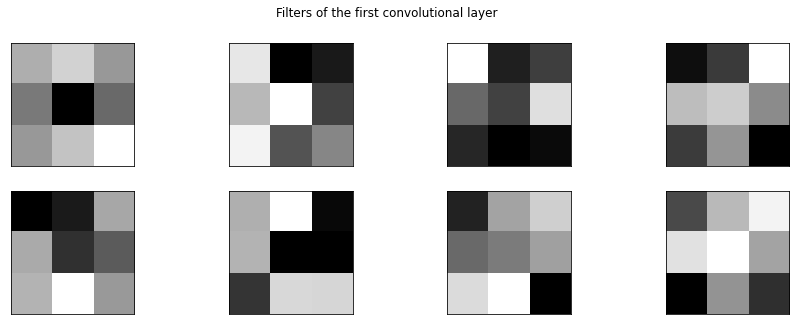

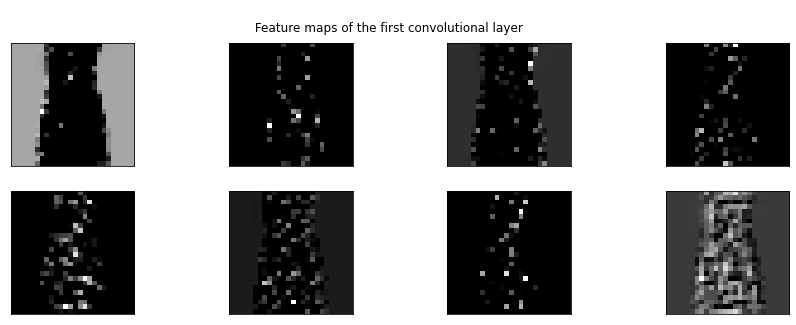

In [33]:
#first we collect the filters of the first convolutional layer 
#these are 8 as the number of neurons of the layer
net = net_cnn.module_
filters_1 = net.conv1.weight
filters_1 = torch.squeeze(filters_1,1)

filters_1  = filters_1.cpu().detach().numpy()

features = []
input = torch.tensor(classification_data['x_train'][0]).unsqueeze(0).to(device)

#define a funcion that return the squeezed output of the called layer
def get_features_map(self, input, output):
    features.append(output.squeeze(0))

#used the method register_forward_hook to get the features maps
hook_handle = net.conv1.register_forward_hook(get_features_map)
net.eval()
with torch.no_grad():
    out = net(input)
### Remove hook
hook_handle.remove()

#plot the filters and their relative feature maps for the first sample of the test_dataset
plt.figure(figsize=(15,5))
for i in range(1, 9):
    plt.subplot(2,4,i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(filters_1[i-1], cmap='gray')
plt.suptitle('Filters of the first convolutional layer')

act = nn.ReLU()

plt.figure(figsize=(15,5))
for i in range(1, 9):
    plt.subplot(2,4,i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(act(features[0][i-1]).cpu().detach().numpy(), cmap='gray')
plt.suptitle('\n Feature maps of the first convolutional layer')
plt.show()

In [34]:
torch.save(net_cnn.module_.state_dict(), "fm-cnn3.pth")